# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [04:27<00:00, 224File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

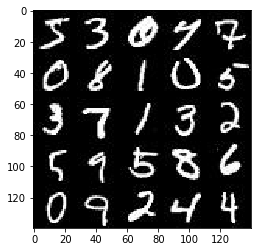

In [117]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

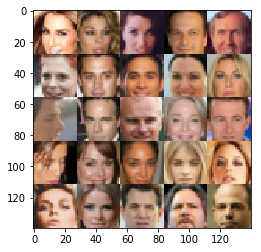

In [118]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [119]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [120]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """    
    
    real_input_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim] )
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [152]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        # Do not apply batch normalization to input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape) # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [155]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse_var = not is_train
    
    with tf.variable_scope('generator', reuse=reuse_var):        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        #print(x3.shape)
        
        # Output layer
        # Do not apply batch normalization to output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.shape)
        # 28x28xout_channel_dim         
        
        out = tf.tanh(logits)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [156]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    real_labels = tf.ones_like(d_model_real) * 0.9 #smoothing        
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [157]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [158]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [159]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                batch_images = batch_images * 2.0 #this is done since range of data is -0.5 to 0.5 and we want -1 to 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, 
                                               z_input: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images,
                                               z_input: batch_z,
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({ real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 2.8796
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 4.1266
Epoch 1/2... Discriminator Loss: 1.6120... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 1.7708
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.8475


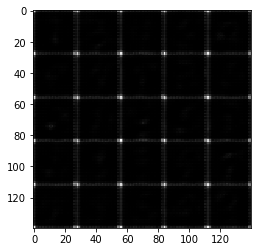

Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 1.0456
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 1.5846
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.1108
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.4937


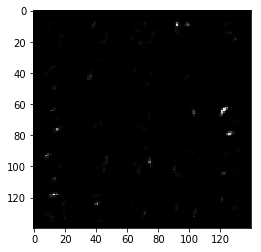

Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.5171... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.4034
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 1.4363
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.7043
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 0.8092
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.2996


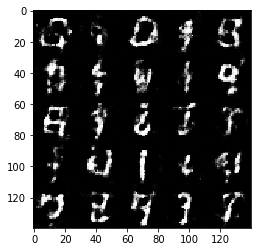

Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.5657
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.0753
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 1.7422
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.4946
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.6226


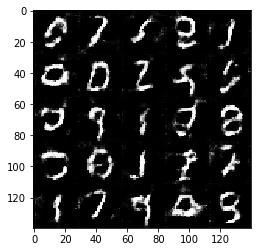

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 1.5455
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.9585


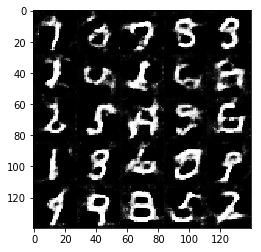

Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.5349
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 0.9766


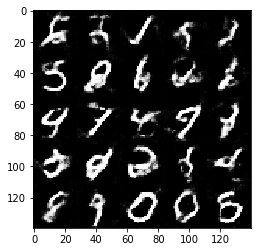

Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 1.4873
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.4612
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 1.0257


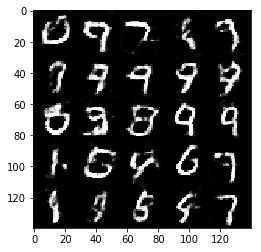

Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 1.3127
Epoch 1/2... Discriminator Loss: 1.0656... Generator Loss: 1.3418
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.5546
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.6804


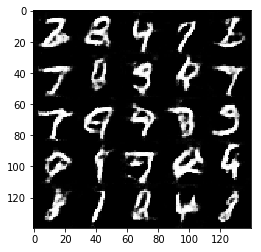

Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.1044
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.9225
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.4856
Epoch 1/2... Discriminator Loss: 1.8113... Generator Loss: 0.4258
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.0844


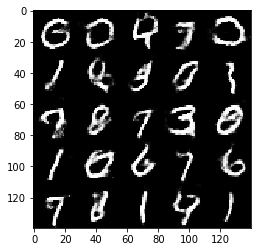

Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.3360
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 1.7640
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 1.3154
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.5347


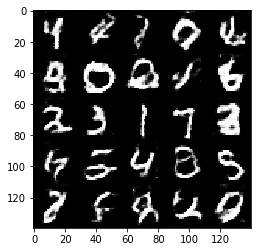

Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 1.1588
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.2998
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 1.6296


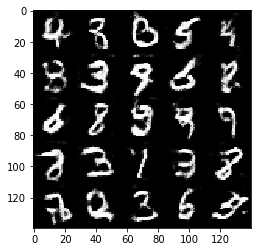

Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 1.2453
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.1617


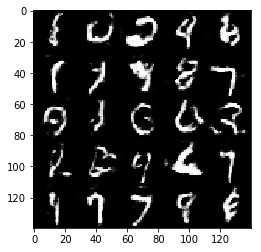

Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.3293
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.8955


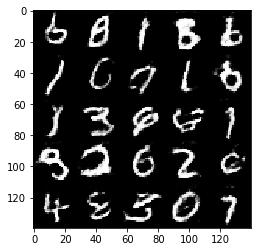

Epoch 2/2... Discriminator Loss: 1.8642... Generator Loss: 2.9184
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 1.1279
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.9707
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.7536


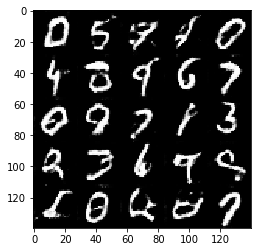

Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.3977
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 1.5908
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.5652
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 0.9048


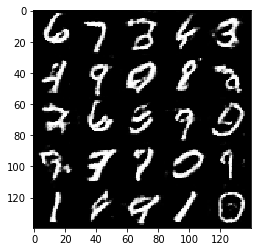

Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.1553


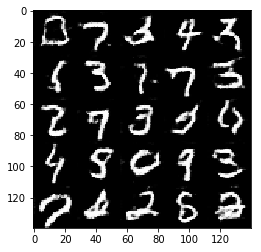

Epoch 2/2... Discriminator Loss: 1.7280... Generator Loss: 0.4011
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 0.8428... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 1.2678
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.1254
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 1.0206


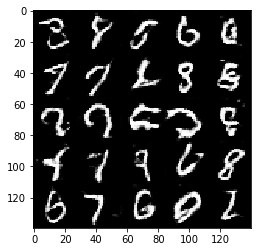

Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.3515
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.5102
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 2.1034
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.0546


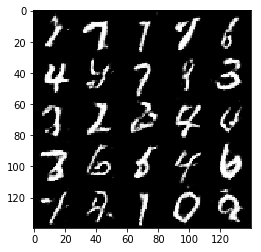

Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.1258
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.3697


In [160]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.8756
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 4.9396
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.7795
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.5953
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.9247
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.2828


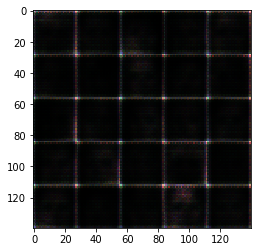

Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 2.2607
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 2.5280
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 4.6157
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5946


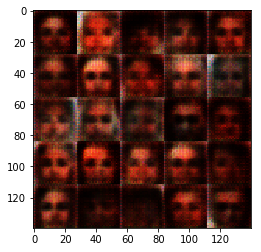

Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 2.7615
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.7091
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.3969


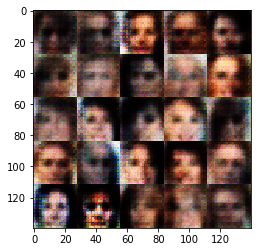

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 3.2257
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 2.0231


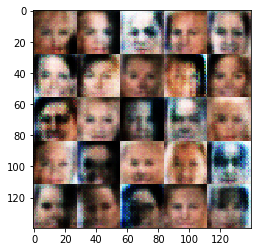

Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 2.7069
Epoch 1/1... Discriminator Loss: 2.1809... Generator Loss: 0.2071
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 2.4866
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.6977


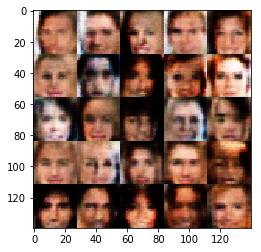

Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 3.0672
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 3.0162
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 2.9136


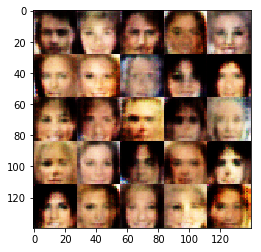

Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 4.7241
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.2865
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.2771


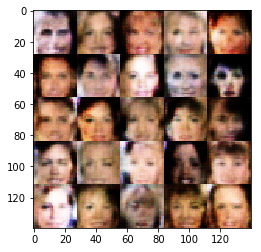

Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.0564
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.5426
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.4410
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 4.0617
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 4.0317
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.8232


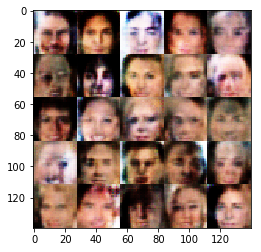

Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.7974
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.6698
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 2.8988
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.7201
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 2.7165
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.1317
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.9782
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 2.6096
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 3.8374


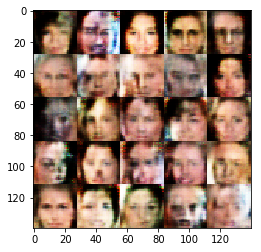

Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 5.1442
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 5.6301
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.4008
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 3.4319
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 4.4810
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.1133
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 5.4516


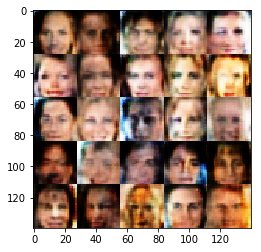

Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 4.6349
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.1200
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.2379
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.9040
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.2265
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.3254


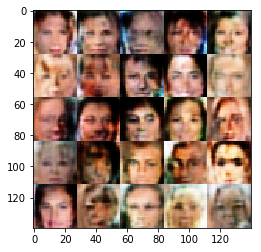

Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.3440
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.2166
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 4.3300
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.7289
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 3.2069
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 3.0131
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 3.9976
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.6402
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 2.8535


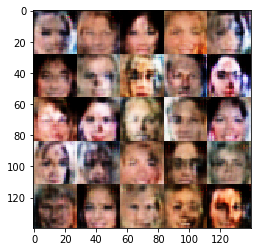

Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.4828
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 4.0574
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.8672
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.8860
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.6158
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 3.9395
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 4.0850
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.9526


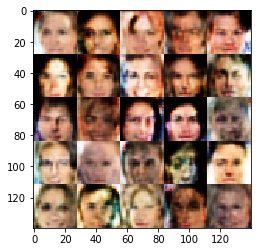

Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.5138
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.0595
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.8615
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 2.8383
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 4.1489


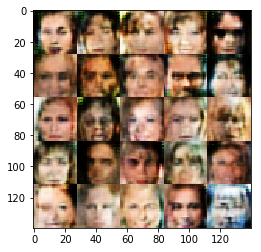

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.2405
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.5444
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.5625


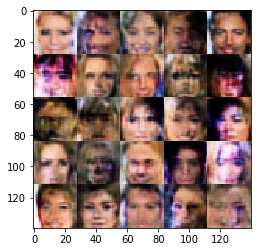

Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.5220
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 3.9310
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 3.6842
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 3.0696
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.9889
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 3.9669
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.7547


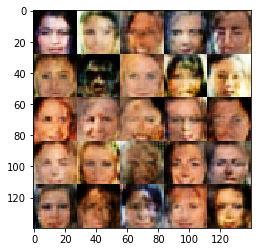

Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 2.9081
Epoch 1/1... Discriminator Loss: 3.0077... Generator Loss: 0.1057
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 3.5245
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.9983
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 1.8862
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 3.4458


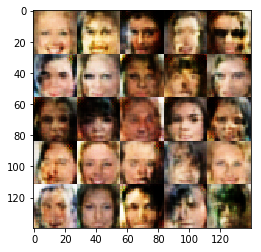

Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.8494
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 2.6493... Generator Loss: 3.4710
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.5556
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 4.1725
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.2392
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 2.9367


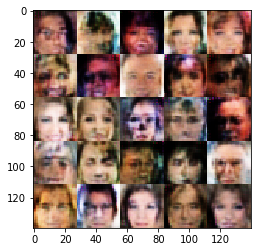

Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 2.1625
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.6492
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.9517
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.3276
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.9610
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.2870
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.5236
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 2.0059


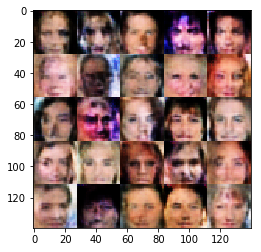

Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.5146
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.7876
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 2.4022
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.7458


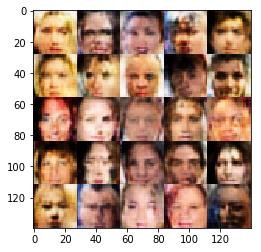

Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.6575
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 3.1431
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.9345
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.4886


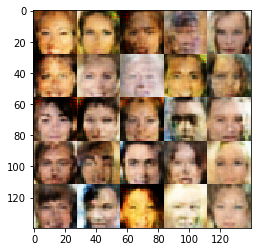

Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.3550
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.4943
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 2.3530
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.0991
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.9450


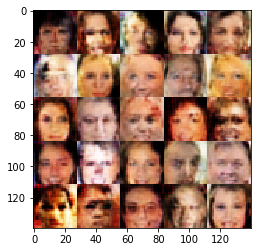

Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.2763
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.7465
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 1.8414
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 2.6786
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.6602
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 4.3597
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 2.7335


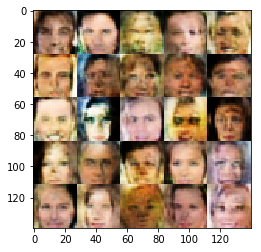

Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.4302
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.6280
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 4.2696
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.7576
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.3755


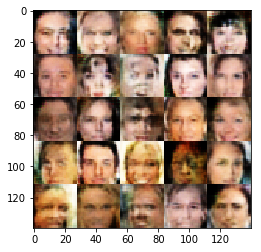

Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 2.7920
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 3.7900
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.8037
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.7423... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.8531


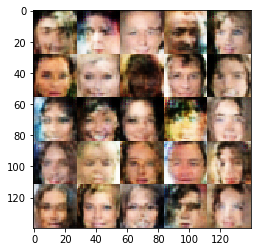

Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 3.1274
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.3887
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 4.2414
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.7922
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 3.8969


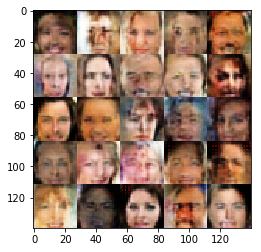

Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 3.1344
Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 1.9240
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.7639
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.9197
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.5782


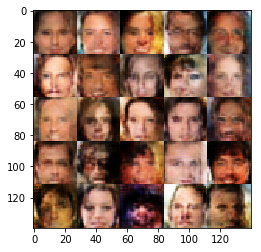

Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.6929
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.3189
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 2.0848
Epoch 1/1... Discriminator Loss: 1.9507... Generator Loss: 0.2866
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 4.4455
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 4.5780


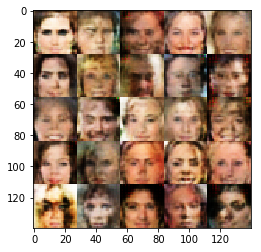

Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 3.4635
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 3.9973
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 2.4931
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 3.2210
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 3.1120


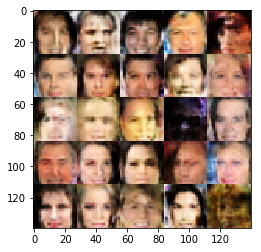

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 2.1245... Generator Loss: 4.1517
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.0872
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 3.2883
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.8129


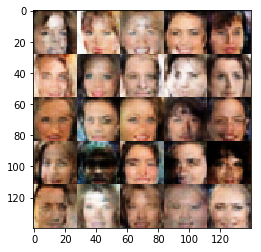

Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 3.2847
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 2.4888
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.7720
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.2385
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.0947


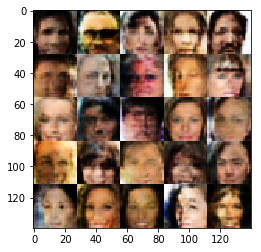

Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.8706


In [161]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.